## 🟢Imports

In [1]:
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


## 🟢Load Processed data

In [2]:
# Use project-relative paths (not absolute) so repo runs on other machines/CI
project_root = Path.cwd().parent
data_path = project_root / 'data' / 'processed.csv'
encoders_path = project_root / 'out' / 'encoders.pkl'

df = pd.read_csv(data_path)
encoders = joblib.load(encoders_path)

print(f"Processed data shape: {df.shape}")
df.head()

Processed data shape: (752, 8)


,Season,team1,team2,toss_winner,toss_decision,venue,winner,Home_advantage
0,9,14,13,13,1,28,14,1
1,9,8,11,11,1,21,11,0
2,9,4,7,7,1,31,7,1
3,9,11,5,5,1,13,5,0
4,9,13,3,13,0,17,13,1


## 🟢Define features and Target

In [3]:
# Drop target column from features
x = df.drop(columns=["winner"])
y = df["winner"]

print(f"Feature shape: {x.shape}")
print(f"Target distribution: \n {y.value_counts()}")

Feature shape: (752, 7)
Target distribution: 
 winner
8     109
0     100
7      92
13     84
5      82
10     75
3      67
14     58
1      29
4      13
9      12
11     10
2      10
6       6
12      5
Name: count, dtype: int64


## 🟢Time-Aware Train/Test Split

In [4]:
# Sort by Season (to avoid data leakage from future seasons)
df_sorted = df.sort_values(by='Season')

# Define features and labels again
X = df_sorted.drop(columns=['winner'])
y = df_sorted['winner']

# Split using 80% old seasons for training, 20% recent for testing
split_index = int(0.8 * len(df_sorted))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 601, Testing samples: 151


## 🟢Train Logistic Regression Model

In [5]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")


Logistic Regression Accuracy: 0.0464


d:\PYTHON\Projects\Cricket-win-predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 🟢Train Random Forest Model

In [6]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {acc_rf:.4f}")


Random Forest Accuracy: 0.4768


## 🟢Compare Model performance

In [7]:
print("\nModel Comparison:")
print(f"Logistic Regression: {acc_lr:.4f}")
print(f"Random Forest: {acc_rf:.4f}")

best_model = rf if acc_rf >= acc_lr else log_reg
best_name = "Random Forest" if acc_rf >= acc_lr else "Logistic Regression"
print(f"\n✅ Best Model: {best_name}")



Model Comparison:
Logistic Regression: 0.0464
Random Forest: 0.4768

✅ Best Model: Random Forest


## 🟢Confusion Matrix Visualization

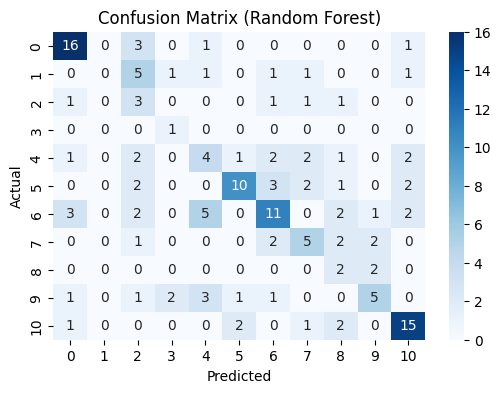

In [8]:
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix ({best_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 🟢Classification Report

In [9]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        21
           2       0.00      0.00      0.00        10
           3       0.16      0.43      0.23         7
           4       0.25      1.00      0.40         1
           5       0.29      0.27      0.28        15
           7       0.71      0.50      0.59        20
           8       0.52      0.42      0.47        26
          10       0.42      0.42      0.42        12
          11       0.18      0.50      0.27         4
          13       0.50      0.36      0.42        14
          14       0.65      0.71      0.68        21

    accuracy                           0.48       151
   macro avg       0.40      0.49      0.41       151
weighted avg       0.49      0.48      0.47       151



d:\PYTHON\Projects\Cricket-win-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\PYTHON\Projects\Cricket-win-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\PYTHON\Projects\Cricket-win-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

## 🟢Save best model

In [10]:
# ✅ Use project-relative path for output model
model_path = project_root / 'out' / 'model.pkl'

# Ensure directory exists
os.makedirs(model_path.parent, exist_ok=True)

# Save the best model
joblib.dump(best_model, model_path)
print(f"✅ Model saved successfully to {model_path}")


✅ Model saved successfully to d:\PYTHON\Projects\Cricket-win-predictor\out\model.pkl


## 🟢Quick Sanity Check

In [11]:
# Reload model to verify
model_loaded = joblib.load(model_path)
sample_pred = model_loaded.predict(X_test.head(1))
print("Sample Prediction:", sample_pred)


Sample Prediction: [13]
